In [1]:
import pandas as pd
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,O=C(c1noc(-c2ccccc2)n1)N1CCC(Oc2ccc(CN3CCCC3)c...,5.12,432.524,4.01600,0.586002,[0 0 1 ... 0 0 0]
1,CN(CCN1CCN(C2COOC2)C1=O)CC12CCC(CC1)C2(C)C,5.20,351.491,2.20260,0.688448,[0 0 0 ... 0 0 0]
2,CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3c(C)nc4ccc(F)c...,5.69,425.935,5.54292,0.582694,[0 0 0 ... 0 0 0]
3,COc1cc(N2CCN(CCO)CC2)ccc1N=c1nc(-c2cnc3ccccn23...,5.43,479.972,2.73310,0.441384,[0 0 0 ... 0 0 0]
4,CNC(C)c1cc(F)ccc1Oc1ccc(Cl)c(Cl)c1,5.17,314.187,5.20520,0.836697,[0 0 0 ... 0 0 0]
...,...,...,...,...,...,...
1257,CC1(N)CCC(N=c2c(C(N)=O)c[nH]n3cc(-c4cccc(F)c4)...,5.12,395.482,2.97910,0.634812,[0 0 0 ... 0 0 0]
1258,CCc1cc(Oc2cc(Cl)ccc2CNC)ccc1Cl,5.94,310.224,5.06750,0.832455,[0 0 0 ... 0 0 0]
1259,COc1cc(-c2cn(C3CC([Si](C)(C)C)CCNC3=O)nn2)ccc1...,5.20,438.608,3.60732,0.615122,[0 0 0 ... 0 0 0]
1260,CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4cc(F)cc(F)...,6.24,429.898,5.37360,0.591999,[0 0 0 ... 0 0 0]


In [23]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [24]:
smiles = df['Standardized_SMILES'].values

In [25]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [26]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(CC(C)(C)C)N1CCC(CNC(=O)c2cc(Cl)cc(Cl)c2)CC1,5.66,385.379,5.25990,0.749922,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(Cc2ccc(C(...,5.60,482.568,4.16450,0.594707,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Oc1ccc(-c2cc3c(CN4CCC5(COC5)C4)c(O)ccc3o2)cc1,5.37,351.402,3.73330,0.752559,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1COc2ccc(CNC34CCC(CCc5c(F)cnc6ccc(OCCCCCO)n...,6.16,565.646,3.84040,0.280757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,O=C1COc2ccc(CNC34CCC(CCc5c(F)cnc6cc(Cl)cnc56)(...,8.48,497.958,3.95240,0.531702,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,O=C(O)CCCCOc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5...,4.36,579.629,3.93270,0.269960,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2nc3cc(F)c...,5.33,483.548,3.02460,0.419550,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,COc1cc(C(O)(CCN(C)C)C(c2cc3cc(Br)ccc3nc2OC)c2c...,5.58,627.536,4.80170,0.235417,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
#Now incorporate this sort of noise into df during the training

In [28]:
import xgboost as xgb

In [29]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt


def perform_cv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train1 =np.vstack([X[:start]])
        X_train2=np.vstack([X[stop+1:]])
        X_train=np.vstack([X_train1,X_train2])

        y_train = np.delete(y.copy(), slice(start, stop + 1))
        model =xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("cv_results_xgboost.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.8374632472807104, pvalue=2.4574629693541148e-34)
PearsonRResult(statistic=0.8695236491939733, pvalue=8.399598874528856e-40)
PearsonRResult(statistic=0.8114129467058855, pvalue=1.0523501181467964e-30)
PearsonRResult(statistic=0.8861944696506774, pvalue=2.9811042314586573e-43)
PearsonRResult(statistic=0.8575338467283751, pvalue=1.3306794585215716e-37)
PearsonRResult(statistic=0.8374272651815884, pvalue=2.488502987054328e-34)
PearsonRResult(statistic=0.8656602574348857, pvalue=4.5306365543098104e-39)
PearsonRResult(statistic=0.8697056308954396, pvalue=7.748343766853542e-40)
PearsonRResult(statistic=0.8404326695600856, pvalue=2.514299960583632e-35)


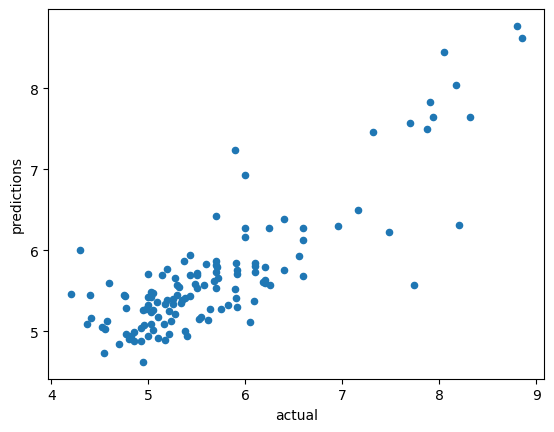

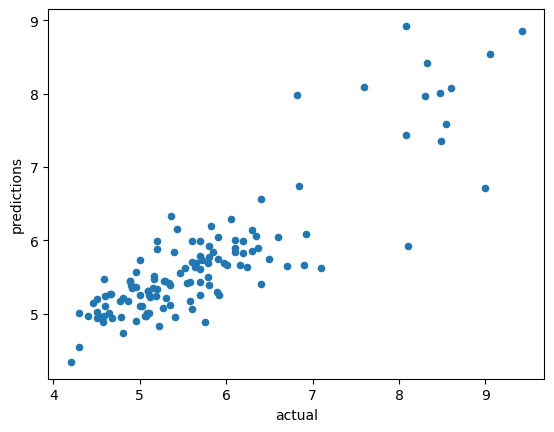

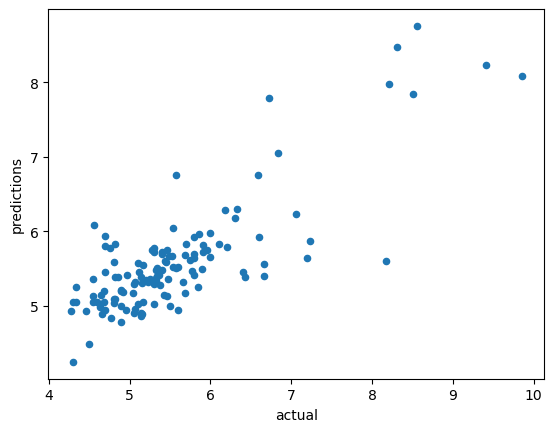

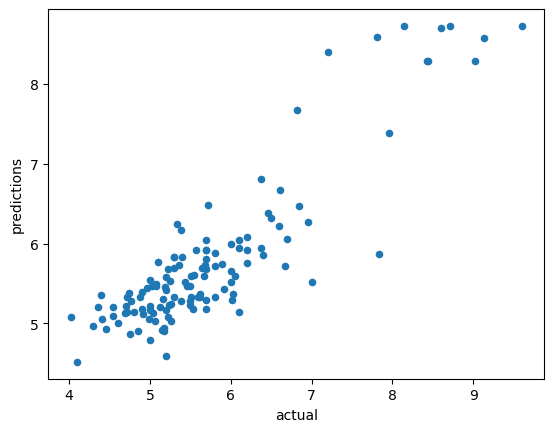

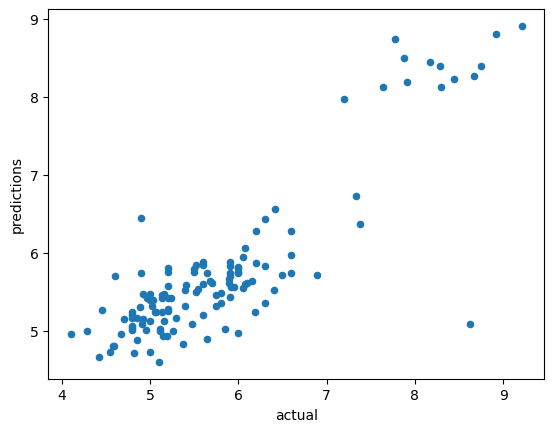

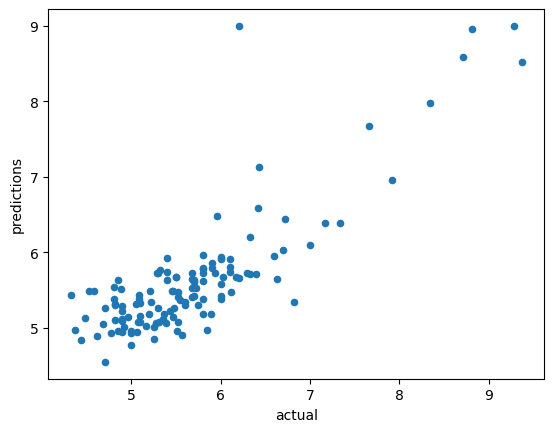

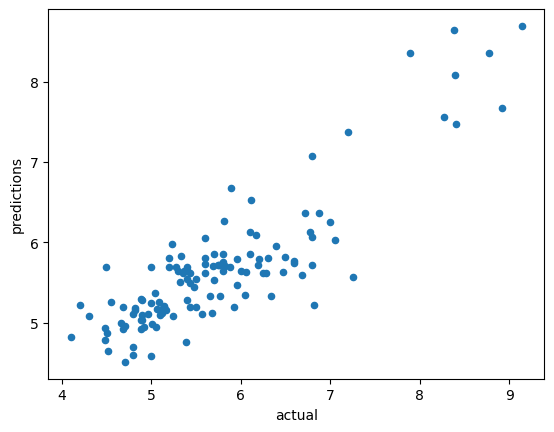

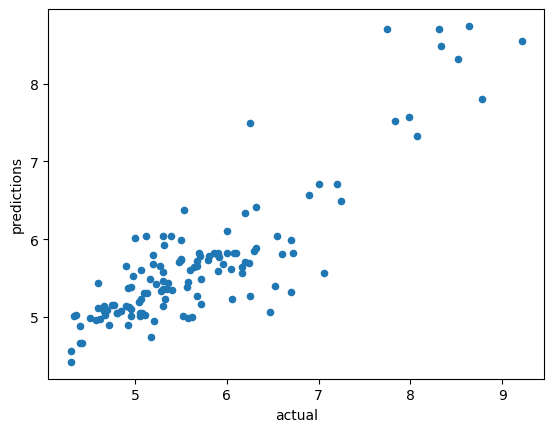

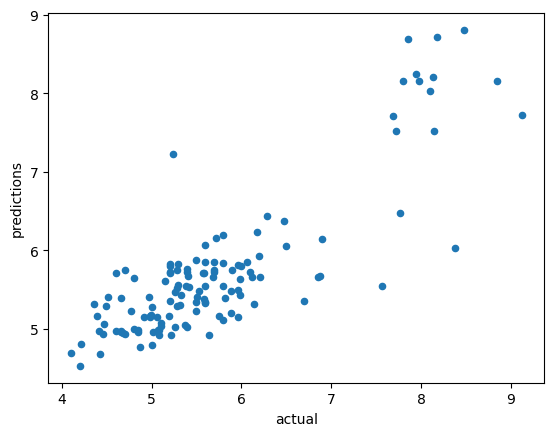

In [30]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_cv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [31]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(23, 3)
(24, 3)
(31, 3)
(22, 3)
(27, 3)
(22, 3)
(33, 3)
(32, 3)
(30, 3)


In [32]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(8, 3)
(7, 3)
(6, 3)
(5, 3)
(8, 3)
(14, 3)
(7, 3)
(7, 3)
(9, 3)


In [33]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(22, 3)
(22, 3)
(21, 3)
(19, 3)
(18, 3)
(16, 3)
(10, 3)
(12, 3)
(11, 3)


In [34]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(73, 3)
(70, 3)
(67, 3)
(76, 3)
(67, 3)
(73, 3)
(74, 3)
(73, 3)
(73, 3)


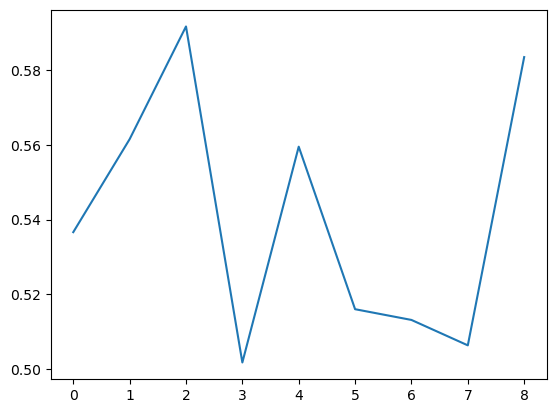

[0.5366205096308806, 0.5615621873114123, 0.5917908125798834, 0.5016665715712123, 0.5595483107403972, 0.5159567120505646, 0.5130771520778298, 0.506258560438421, 0.5835814508424151]


In [35]:
plt.plot(rmse)
plt.show()
print(rmse)

In [36]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

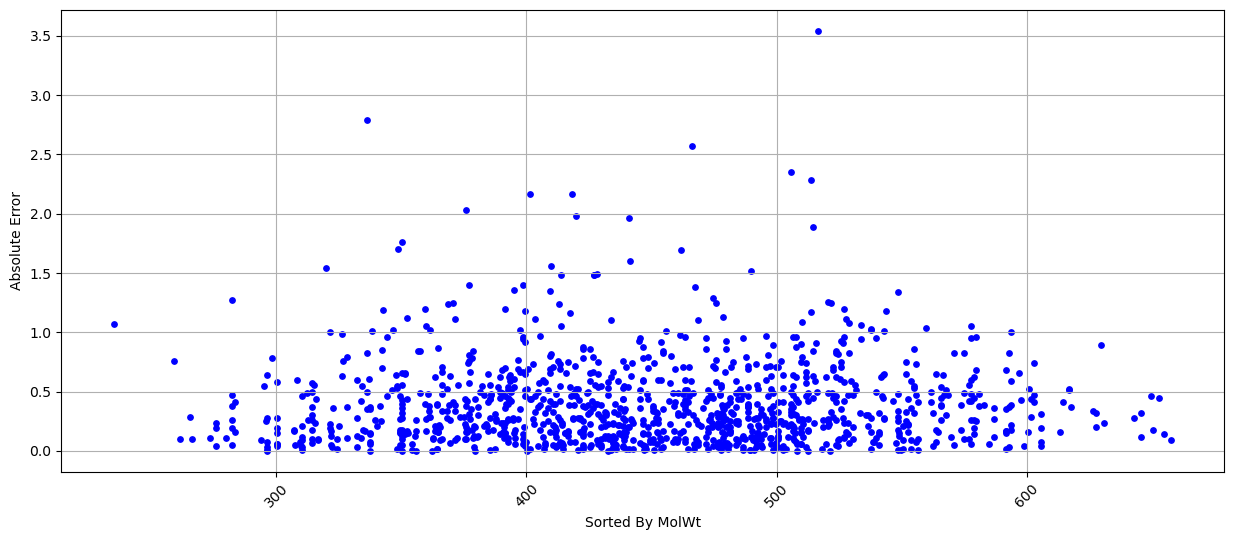

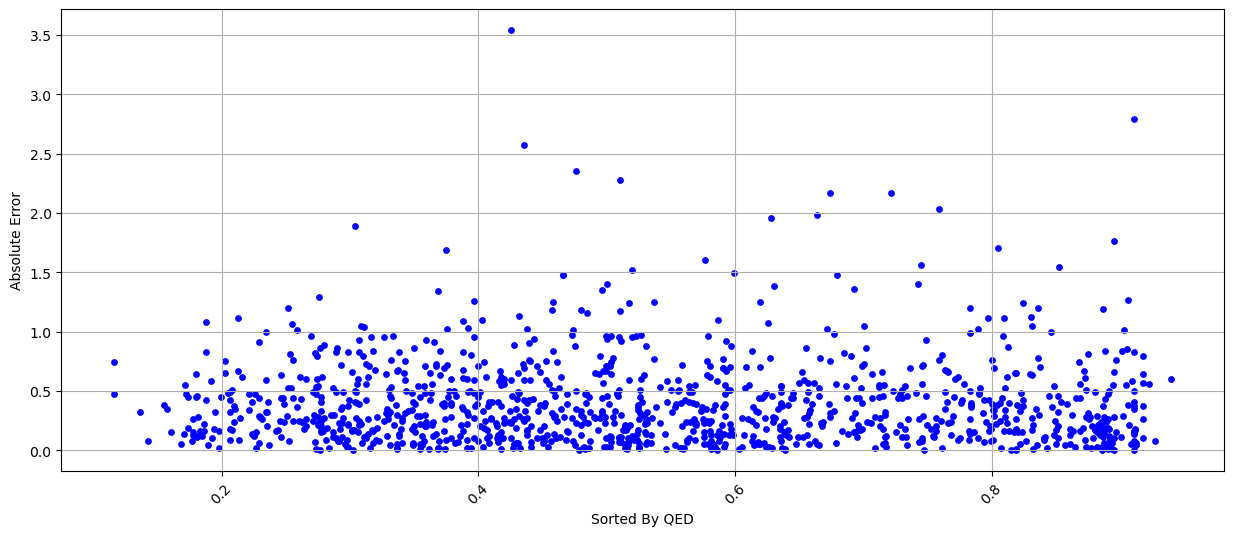

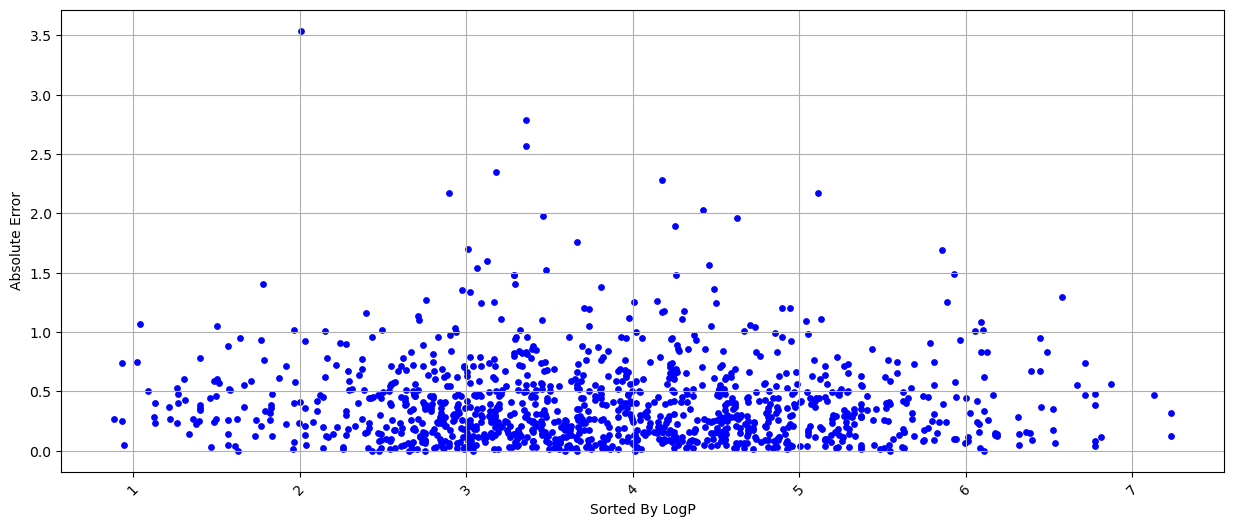

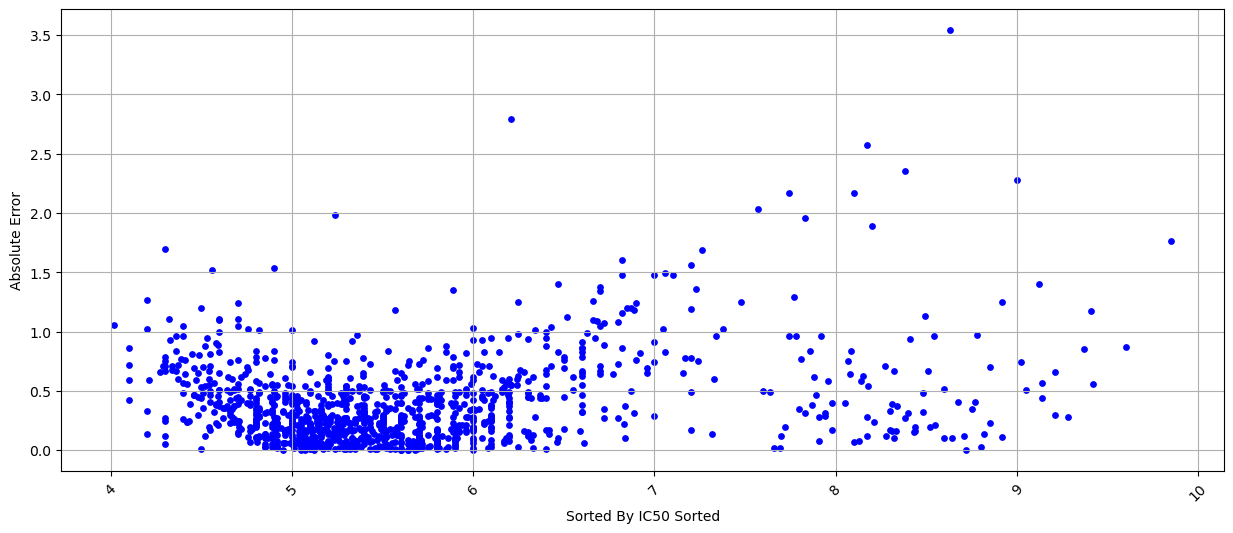

In [37]:
plot_graphs(df, results_df)

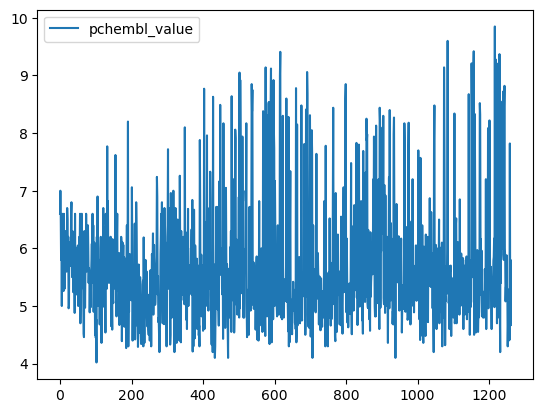

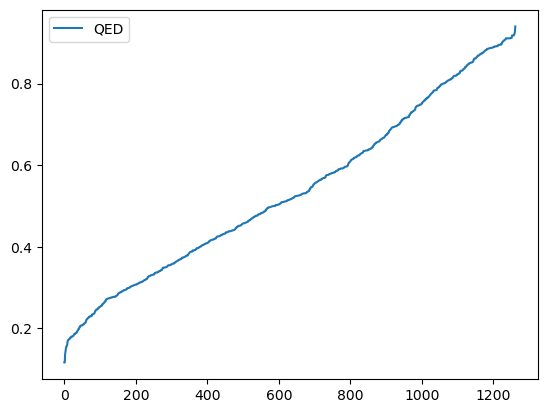

In [38]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [39]:
smiles1.shape

(1136,)

In [40]:
smiles_test.shape

(126,)

In [41]:
y_test.shape

(126,)

In [42]:
y1.shape

(1136,)

In [43]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_cv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train1 =np.vstack([X[:start]])
        X_train2=np.vstack([X[stop+1:]])
        X_train=np.vstack([X_train1,X_train2])
        
        y_train = np.delete(y.copy(), slice(start, stop + 1))
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all
                        })

    # Saving to CSV (optional)
    results_df.to_csv("cv_results_most_druglike_xgboost.csv", index=False)


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.7868552127590902, pvalue=9.198908279316873e-28)
PearsonRResult(statistic=0.8090064650412087, pvalue=2.1332665808322865e-30)
PearsonRResult(statistic=0.8670620598570997, pvalue=2.4731477858990023e-39)
PearsonRResult(statistic=0.8261561952801502, pvalue=1.098816520567704e-32)
PearsonRResult(statistic=0.8043885568533047, pvalue=8.05257973016825e-30)
PearsonRResult(statistic=0.74165082863874, pvalue=3.0047220144649944e-23)
PearsonRResult(statistic=0.8485534981874187, pvalue=4.405579261629077e-36)
PearsonRResult(statistic=0.819022888217632, pvalue=1.0519971357092533e-31)
PearsonRResult(statistic=0.8251601371650388, pvalue=1.515595368089139e-32)


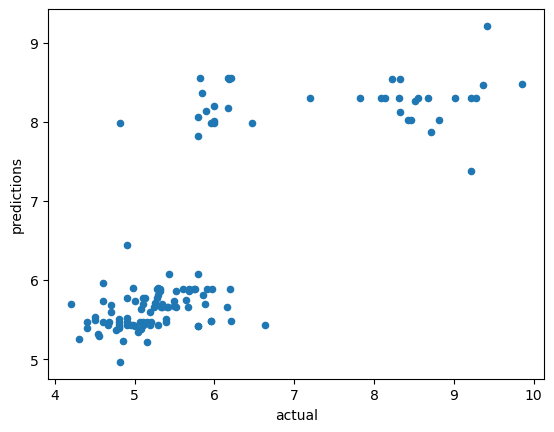

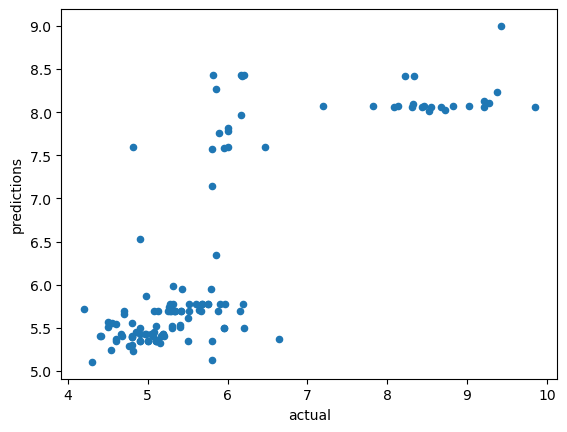

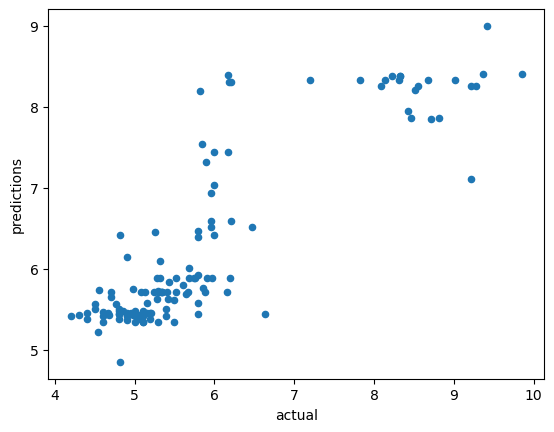

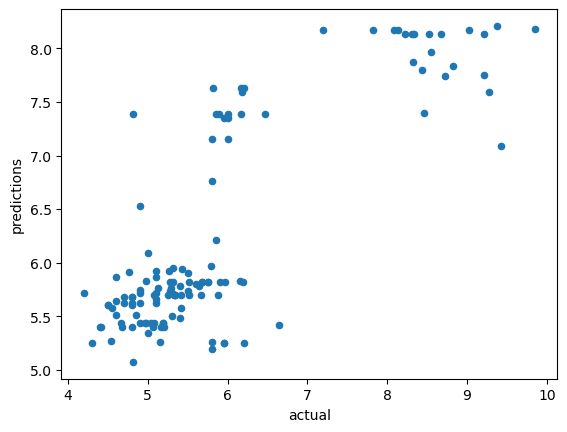

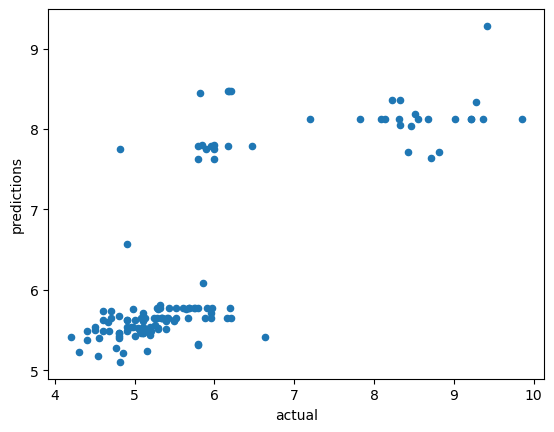

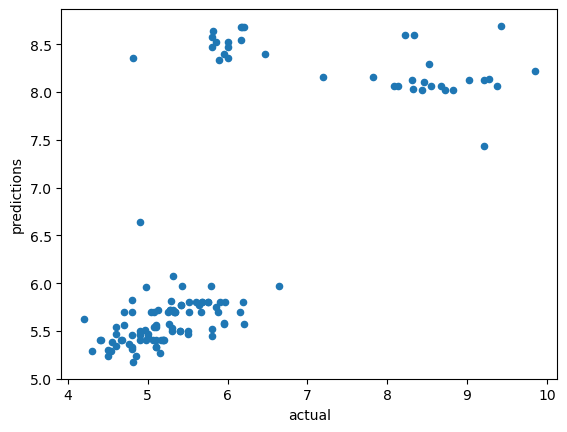

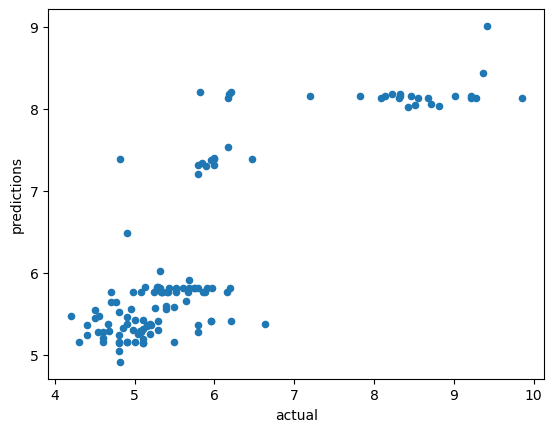

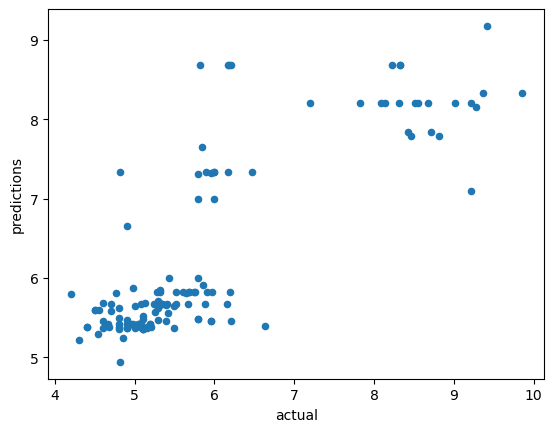

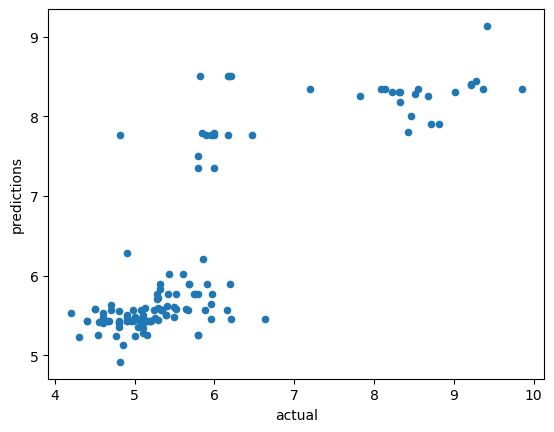

In [44]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_cv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [45]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(1, 3)
(1, 3)
(1, 3)
(1, 3)
(2, 3)
(1, 3)
(12, 3)
(1, 3)
(2, 3)


In [46]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(1, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)


In [47]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(77, 3)
(76, 3)
(77, 3)
(76, 3)
(77, 3)
(77, 3)
(76, 3)
(77, 3)
(77, 3)


In [48]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(47, 3)
(47, 3)
(47, 3)
(47, 3)
(46, 3)
(47, 3)
(36, 3)
(47, 3)
(46, 3)


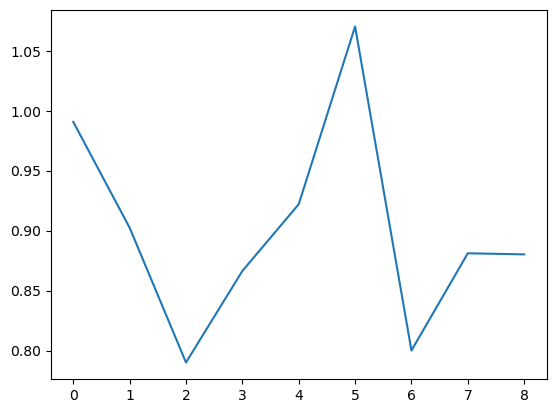

[0.9906953071030156, 0.9024089429098487, 0.7900622153608334, 0.8663593842901505, 0.9220069591243205, 1.0702284074716613, 0.8000428796700927, 0.8811179551718065, 0.8801973610788325]


In [49]:
plt.plot(rmse)
plt.show()
print(rmse)